In [ ]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d

import time


[]
TensorFlow version: 2.15.0


In [ ]:
model_load = load_model("/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/ml_model/april24_2024_model_unfDist_LDC_size_horz_scale.h5")
# model_load = load_model("/content/drive/MyDrive/5_AstroFYP_data/april_9_model_training/april9_2024_model_unfDist_LDC_size_horz_scale.h5")


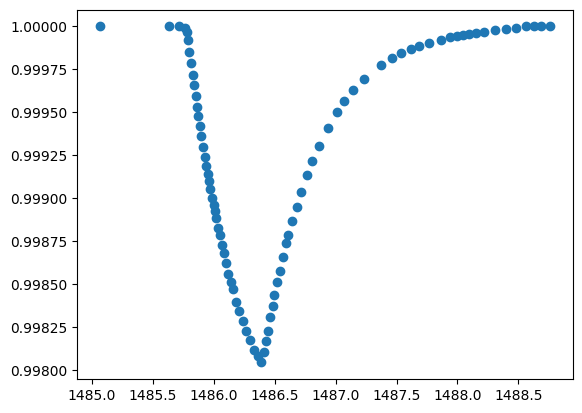

In [ ]:
## Load exocomet LC
exocomet = np.loadtxt('/content/drive/MyDrive/5_AstroFYP_data/exocomet_lc/2March24_exocometlc_v1.csv', delimiter=",")

# Plot
org_flux = exocomet[:,1]
org_time = exocomet[:,0]
plt.scatter(org_time, org_flux)

plt.show()


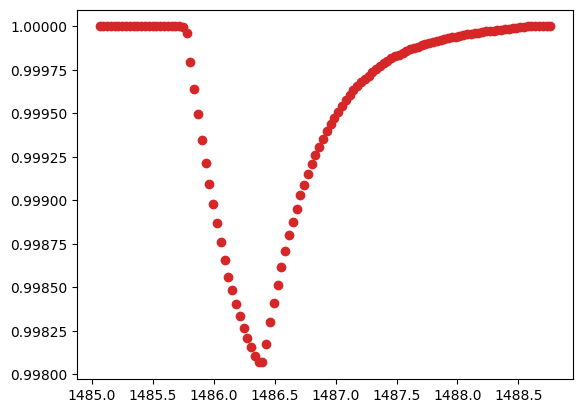

In [ ]:
# Interpolate more uniformly
# Interpolate lc to 120 points
# Define the new x values with 120 points
new_time = np.linspace(org_time.min(), org_time.max(), 120)

# Interpolate y values corresponding to the new x values
new_flux = np.interp(new_time, org_time, org_flux)

fig,ax = plt.subplots(1, 1, dpi=100)

ax.scatter(new_time, new_flux,color='tab:red')
# ax.plot(org_time, org_flux, color='tab:blue')

plt.show()

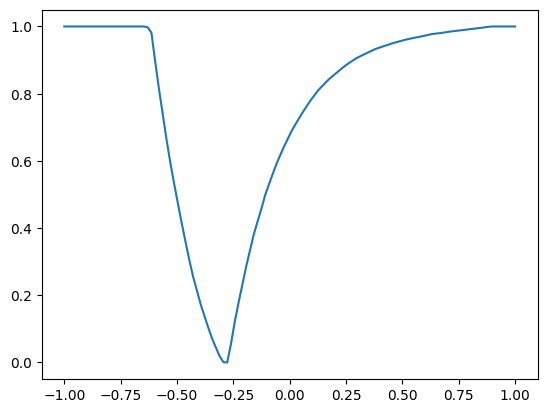

Extended the light curves


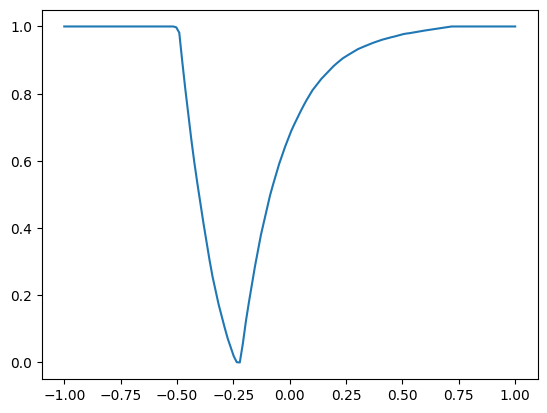

In [ ]:
# Vertical Scale the light curve
test_lc = new_flux
test_lc_scaled = np.zeros(test_lc.shape)
test_lc_scaled = (test_lc - np.amin(test_lc))/(np.amax(test_lc) - np.amin(test_lc))
plt.plot(np.linspace(-1,1,len(test_lc_scaled)), test_lc_scaled)
plt.show()

# Extend the light curve
test_lc_scaled_append = np.ones(150)
test_lc_scaled_append[15:135] = test_lc_scaled
print("Extended the light curves")
plt.plot(np.linspace(-1,1,len(test_lc_scaled_append)), test_lc_scaled_append)
plt.show()

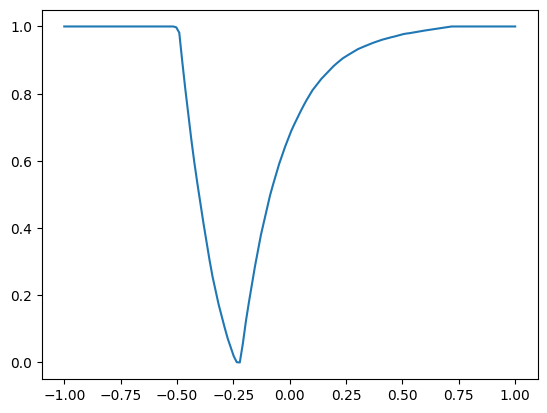

In [ ]:
# Reshape light curve
test_lc_scaled_append = np.reshape(test_lc_scaled_append,(1,150))
plt.plot(np.linspace(-1,1,len(test_lc_scaled_append[0])), test_lc_scaled_append[0])
plt.show()

Length of one LC =  150
input_lc_dataset_interpol.shape = (1, 120)
center_index = 75
left_index = 25
right_index = 125
Length = 101


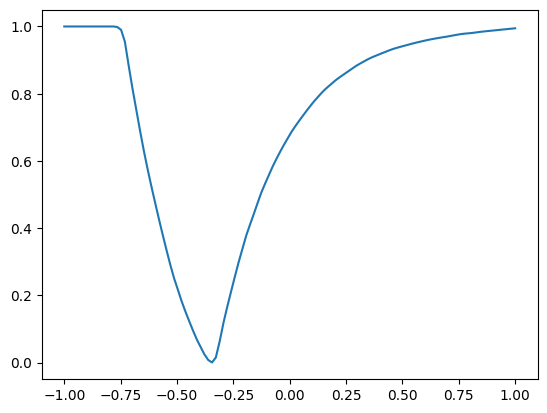

In [ ]:
# 5. Horizontal scaling
def scale_horizontally(input_lc_dataset):
    # lc_np_array_offset_mask used to select the flat part by certain percentage
    input_lc_dataset_mask = np.copy(input_lc_dataset)

    for iteration in np.arange(len(input_lc_dataset)):
        # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]>=0.98)] = 1.0
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]<0.98)] = 0.0

    print("Length of one LC = ", len(input_lc_dataset_mask[0]))

    count_zeros_array = np.zeros((len(input_lc_dataset_mask),))
    for iteration in np.arange(len(input_lc_dataset_mask)):
        # Calculate the number of occurrences of '0'
        count_zeros = np.count_nonzero(input_lc_dataset_mask[iteration] == 0)
        count_zeros_array[iteration] = count_zeros

    # Interpolate the light curve
    input_lc_dataset_interpol = np.zeros((len(input_lc_dataset), 120))
    len_selected_portion = np.zeros(len(input_lc_dataset))
    print("input_lc_dataset_interpol.shape =", input_lc_dataset_interpol.shape)

    center_index = int(len(input_lc_dataset[0])/2)
    print("center_index =", center_index)

    for iteration in np.arange(len(input_lc_dataset_interpol)):

        left_index = int(center_index - int(count_zeros_array[iteration]/2) - int(count_zeros_array[iteration]/6))
        right_index = int(center_index + int(count_zeros_array[iteration]/2) + int(count_zeros_array[iteration]/6))
        selected_portion = input_lc_dataset[iteration][left_index:right_index]
        print("left_index =", left_index)
        print("right_index =", right_index)
        print("Length =", right_index-left_index+1)

        # Calculate the length of the selected region
        len_selected_portion[iteration] = len(selected_portion)

        # Interpolate the selected portion
        # Original data
        original_x = np.linspace(-1, 1, num=len(selected_portion))
        original_y = selected_portion

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='linear')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=120)

        # Perform the interpolation
        y_interpolated = f(x_interpolation)

        # # Replacing end elements with 1

        # y_interpolated[0:9] = np.ones(len(y_interpolated[0:9]))
        # # print(f"len(y_interpolated[0:9])) = {len(y_interpolated[0:9])}")

        # y_interpolated[111:120] = np.ones(len(y_interpolated[111:120]))
        # # print(f"len(y_interpolated[111:120])) = {len(y_interpolated[111:120])}")

        input_lc_dataset_interpol[iteration] = y_interpolated

    return input_lc_dataset_interpol

test_lc_horiz_scaled = scale_horizontally(test_lc_scaled_append)
# del test_lc_scaled_append

plt.plot(np.linspace(-1,1,len(test_lc_horiz_scaled[0])), test_lc_horiz_scaled[0])
plt.show()


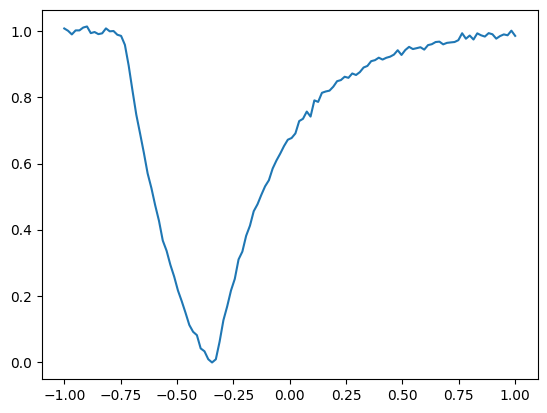

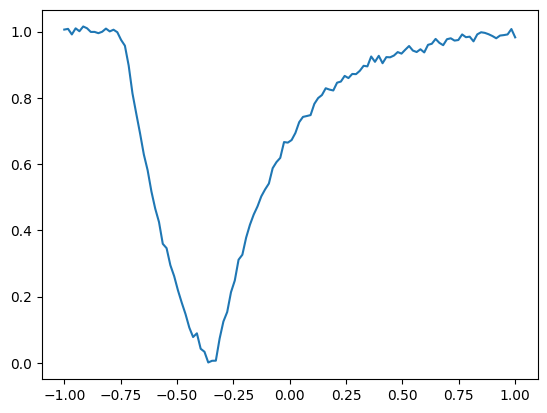

In [ ]:
processed_test_lc = test_lc_horiz_scaled
# del test_lc_horiz_scaled

plt.plot(np.linspace(-1,1,len(processed_test_lc[0])), processed_test_lc[0])
plt.show()

# Noise addition
SNR = 150
std_dev = 1/SNR
noise_temp = np.random.normal(loc=0.0, scale=std_dev, size=len(processed_test_lc[0]))

rng = np.random.default_rng()
rng.shuffle(noise_temp)

processed_test_lc[0] = processed_test_lc[0] + noise_temp
plt.plot(np.linspace(-1,1,len(processed_test_lc[0])), processed_test_lc[0])
plt.show()

In [ ]:
processed_test_lc.shape

(1, 120)

In [ ]:
# Test on the ML model - Test Dataset - Original Simulated light curve
# (i.e. without sampling and interpolation)
# Test dataset - Prediciton
# processed_test_lc = np.zeros(shape=(1,120))
test_predict_shape = model_load.predict(processed_test_lc) # model_load.predict(test_lc_scaled) #
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

1/1 [==============================] - 0s 21ms/step
Normalized the predicted shape


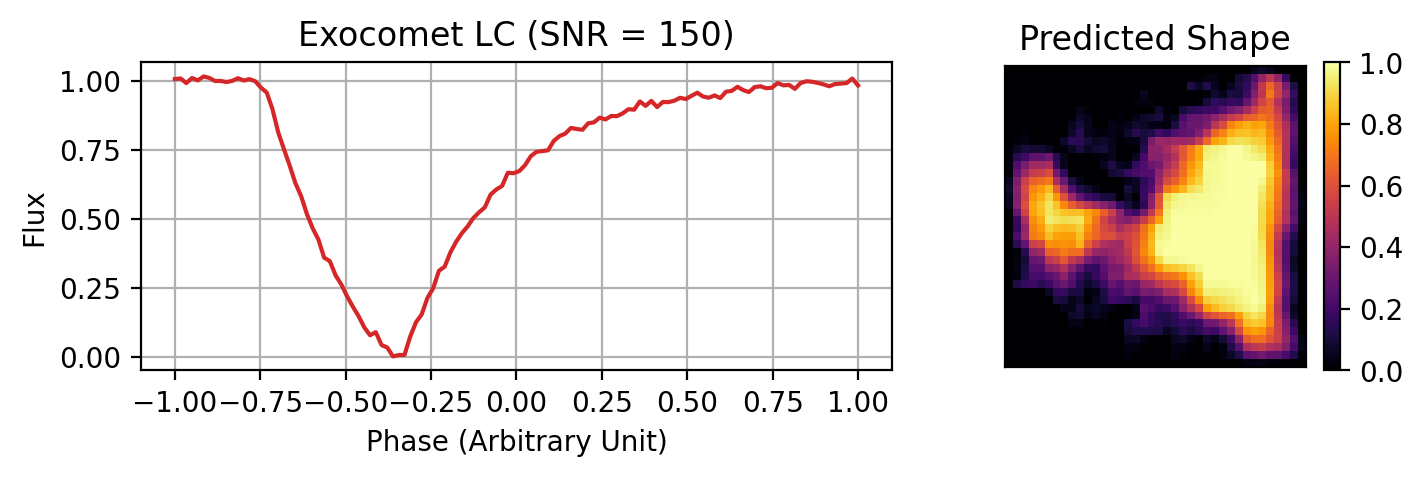

In [ ]:
fig, axes = plt.subplots(1,
                         2,
                         figsize=(8,2),
                         gridspec_kw={'width_ratios': [2,1]},
                         dpi=200)  # 1 row, 2 columns
ph = np.linspace(-1,1,len(processed_test_lc[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title(f"Exocomet LC (SNR = {SNR})")
axes[0].plot(ph, processed_test_lc[k], color='tab:red')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')


axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()
